## Import Images from Video

In [22]:
import cv2
print(cv2.__version__)

4.10.0


In [28]:
from PIL import Image
import os
import shutil

def files(imageFolder, videoPath):
    if not os.path.exists(imageFolder):
        os.makedirs(imageFolder)  
    src_vid=cv2.VideoCapture(videoPath)
    return(src_vid)

def processVideo(src_vid, imageFolder):
    count=1
    while src_vid.isOpened():
        ret, frame=src_vid.read()
        if ret:            
            if count>9960:
                if count%5==0:
                    #Save a frame every 5 frame (6frame/s => one frame every 167ms)
                    name='frame'+str(count)+'.jpg'
                    cv2.imwrite(os.path.join(imageFolder, name), frame)
            
            if count%10000==0:
                print('Processing frame number :', count)
            count+=1
        else:
            break
    src_vid.release()
    cv2.destroyAllWindows()
    return(count)


In [29]:
videoPath='F:/Data_BachelorHES/3.Video_CNC/Video_CNC.mp4'
imageDir='F:/Data_BachelorHES/3.Video_CNC/1.images_frames'
src_vid=files(imageDir, videoPath)
nb_frames=processVideo(src_vid, imageDir)

Processing frame number : 10000
Processing frame number : 20000
Processing frame number : 30000
Processing frame number : 40000
Processing frame number : 50000
Processing frame number : 60000
Processing frame number : 70000
Processing frame number : 80000
Processing frame number : 90000
Processing frame number : 100000
Processing frame number : 110000
Processing frame number : 120000
Processing frame number : 130000
Processing frame number : 140000
Processing frame number : 150000
Processing frame number : 160000
Processing frame number : 170000
Processing frame number : 180000
Processing frame number : 190000
Processing frame number : 200000
Processing frame number : 210000
Processing frame number : 220000
Processing frame number : 230000
Processing frame number : 240000
Processing frame number : 250000
Processing frame number : 260000
Processing frame number : 270000
Processing frame number : 280000


In [34]:
del videoPath, src_vid, nb_frames, imageDir

# Crop images to remove irrelevant parts

In [87]:
def preprocess_with_closing_opening(image, kernel_size=(3,3)):
    """
    Preprocess the image by applying morphological closing followed by opening.
    """
    # Morphological Closing: Fill gaps within characters
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,kernel_size)
    closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=1)
    
    # Morphological Opening: Remove noise
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel, iterations=1)
    
    return opening

In [37]:
def preprocessContours(myImagePath, frameNb, destinationCorrDir='F:/Data_BachelorHES/3.Video_CNC/2.firstCrop/', destinationWrongDir='F:/Data_BachelorHES/3.Video_CNC/2.NotCropped/'):
      
    #load Image
    originalImage = cv2.imread(myImagePath)
    
    #Convert to grayscale
    gray=cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
    #Uncomment below to save intermediary results
    #cv2.imwrite(destinationCorrDir+'Gray_img.jpg', gray)
    
    #Apply CLAHE to improve contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_gray=clahe.apply(gray)
    #Uncomment below to save intermediary results
    #cv2.imwrite(destinationCorrDir+'Clahe_img.jpg', clahe_gray)
   
    #Apply adaptive thresholding
    threshImage=cv2.adaptiveThreshold(clahe_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    #Uncomment below to save intermediary results
    #cv2.imwrite(destinationCorrDir+'Thresh_img.jpg', threshImage)
    
    #Apply morphological opening / closing
    cleanedImage=preprocess_with_closing_opening(threshImage,(1,1))
    
    #Find contours 
    contours, hierarchy = cv2.findContours(cleanedImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #Uncomment below to save intermediary results => This saves a copy with contours in green
    #processedImage=cv2.cvtColor(cleanedImage.copy(), cv2.COLOR_GRAY2BGR)
    #contourImage=cv2.drawContours(processedImage, contours, -1, (0,255,0), thickness=1) 
    #cv2.imwrite(destinationCorrDir+'Contour_img.jpg', contourImage)    
    
    #Iterating over contours to detect potential bounding boxes
    potential_boxes=[]
    for contour in contours:
        (x,y,w,h) = cv2.boundingRect(contour)

        if y>0 and y<140 and x>370 and x<420 and w>230 and h>250: 
        #Draw relevant bounding boxes on image
            area = w*h
            if len(potential_boxes)>0 :
                if area<=potential_boxes[-1][2]*potential_boxes[-1][3]:
                    potential_boxes[-1]=(x,y,w,h) #We want to keep only the box with the smallest area
            else:
                potential_boxes.append((x,y,w,h))
    if len(potential_boxes)>0 :
        myX, myY, myW, myH=potential_boxes[-1] 
        cv2.imwrite('{}cropped_frame_{}.jpg'.format(destinationCorrDir,frameNb), originalImage[myY:myY+myH, myX:myX+myW])
        return True
        #print('Image nb : ', frameNb, ' saved !')
    else: 
        cv2.imwrite('{}uncropped_frame_{}.jpg'.format(destinationWrongDir, frameNb), originalImage)
        print('No potential bounding box found ! for image :', myImagePath)
        return False

#Test of the Preprocessing of the contours of an image
preprocessContours('F:/Data_BachelorHES/3.Video_CNC/1.images_frames/frame131175.jpg', 131175)
    
    

True

In [39]:
from os import listdir
from os.path import isfile, join
mypath='F:/Data_BachelorHES/3.Video_CNC/1.images_frames/'
onlyfiles = [join(mypath,f) for f in listdir(mypath) if isfile(join(mypath, f))]
#file in onlyfiles contain complete path to the image file. Each image file has a name such as frame9855.jpg. 
#We will extract the number of the frame from the name of the file by cutting everything after the "." and everything before the last "frame"  string
unprocessedFiles={"ImageName": [], "frameNb": []}
for idx, file in enumerate(onlyfiles):
    myfileNb=file.split('.')[-2]
    myfileNb=int(myfileNb.split('frame')[-1])
    if idx%1000==0:
        print('Processing file:', myfileNb)
    isProcessed=preprocessContours(onlyfiles[idx], myfileNb)
    if not isProcessed:
        unprocessedFiles["ImageName"].append(file.split('/')[-1])
        unprocessedFiles["frameNb"].append(myfileNb)
        

Processing file: 10000
Processing file: 104545
Processing file: 109090
No potential bounding box found ! for image : F:/Data_BachelorHES/3.Video_CNC/1.images_frames/frame11115.jpg
No potential bounding box found ! for image : F:/Data_BachelorHES/3.Video_CNC/1.images_frames/frame11120.jpg
Processing file: 113635
No potential bounding box found ! for image : F:/Data_BachelorHES/3.Video_CNC/1.images_frames/frame114135.jpg
No potential bounding box found ! for image : F:/Data_BachelorHES/3.Video_CNC/1.images_frames/frame114140.jpg
Processing file: 118180
Processing file: 122725
Processing file: 127270
Processing file: 131815
No potential bounding box found ! for image : F:/Data_BachelorHES/3.Video_CNC/1.images_frames/frame13550.jpg
No potential bounding box found ! for image : F:/Data_BachelorHES/3.Video_CNC/1.images_frames/frame13555.jpg
No potential bounding box found ! for image : F:/Data_BachelorHES/3.Video_CNC/1.images_frames/frame13560.jpg
No potential bounding box found ! for image 

# Check results from First Crop

In [40]:
import pandas as pd 
#Store the width and height of each image in a dataframe to check if there are any anomalies
mypath='F:/Data_BachelorHES/3.Video_CNC/2.firstCrop/'
onlyfiles = [join(mypath,f) for f in listdir(mypath) if isfile(join(mypath, f))]
imageDf = pd.DataFrame()
frameNb=[]
width=[]
height=[]
for f in onlyfiles:    
    myfileNb=f.split('.')[-2]        
    myfileNb=int(myfileNb.split('_')[-1])
    frameNb.append(myfileNb)
    originalImage = cv2.imread(f)
    width.append(originalImage.shape[1])
    height.append(originalImage.shape[0])
imageDf['frameNb']=frameNb
imageDf['width']=width
imageDf['height']=height    

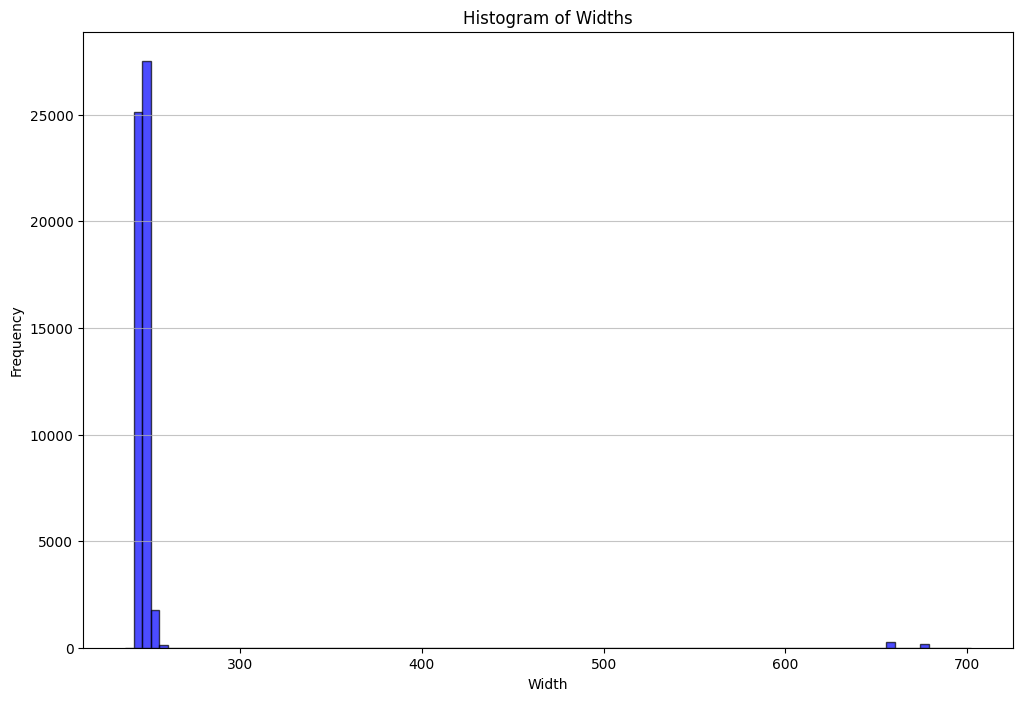

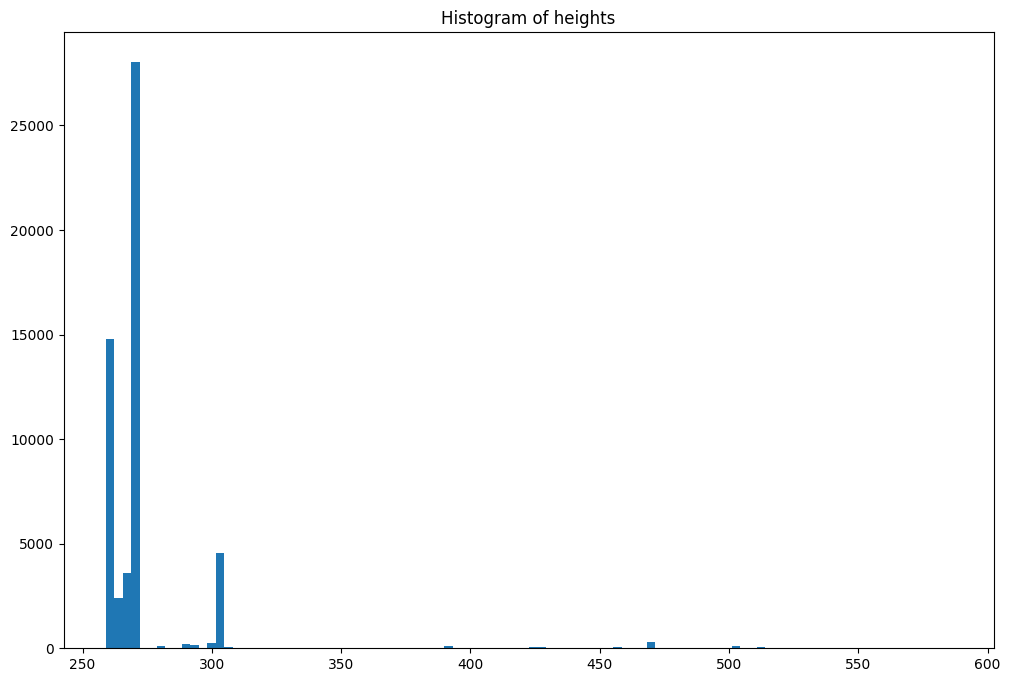

In [47]:
import matplotlib.pyplot as plt
#Display height and widths of cropped images to extract wrongly cropped images
widths = imageDf['width'].to_numpy()  
heights=imageDf['height'].to_numpy()

# Plotting histogram for widths
plt.figure(figsize=(12, 8), facecolor='white')
plt.hist(widths, bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.title("Histogram of Widths")
plt.xlabel("Width")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()


plt.figure(figsize=(12, 8))
plt.hist(heights, bins=100)  
plt.title("Histogram of heights")
plt.show()

In [42]:
import numpy as np 
binsW=np.linspace(imageDf['width'].min(), imageDf['width'].max(), 100)
imageDf['width_bin']=pd.cut(imageDf['width'], bins=binsW)
myHistoW=[imageDf['width_bin'].value_counts().sort_index()]
print(myHistoW)

binsH=np.linspace(imageDf['height'].min(), imageDf['height'].max(), 100)
imageDf['height_bin']=pd.cut(imageDf['height'], bins=binsH)
myHistoH=[imageDf['height_bin'].value_counts().sort_index()]
print(myHistoH)


[width_bin
(237.0, 241.697]          3
(241.697, 246.394]    25113
(246.394, 251.091]    29136
(251.091, 255.788]      171
(255.788, 260.485]      150
                      ...  
(678.515, 683.212]       10
(683.212, 687.909]        0
(687.909, 692.606]        1
(692.606, 697.303]        0
(697.303, 702.0]          1
Name: count, Length: 99, dtype: int64]
[height_bin
(259.0, 262.303]      14195
(262.303, 265.606]     2387
(265.606, 268.909]     3594
(268.909, 272.212]    28052
(272.212, 275.515]       13
                      ...  
(569.485, 572.788]        0
(572.788, 576.091]        0
(576.091, 579.394]        0
(579.394, 582.697]        0
(582.697, 586.0]          1
Name: count, Length: 99, dtype: int64]


In [54]:
print(len([i for i in imageDf['height'] if i>315]))
print(len([i for i in imageDf['width'] if i>300]))
narrowImages=imageDf[imageDf['width']<267]
print(len(narrowImages[narrowImages['height']>315]))

805
457
350


In [55]:
myWrongImage=imageDf[imageDf['width']>267]

In [56]:
myPath= 'F:/Data_BachelorHES/3.Video_CNC/2.firstCropCleaned/' 
myFileName='cropped_frame_'
myPath=myPath+myFileName
myFilesToProcess=[myPath+str(f)+'.jpg' for f in myWrongImage['frameNb'].to_numpy()]


# Second cropping of images based on the histograms of width and height 

In [60]:
#Move images to be recropped in a new directory 
import os
import shutil
destinationDir='F:/Data_BachelorHES/3.Video_CNC/3.imagesToBeRecropped/'
for file_path in myFilesToProcess:
    try:
        shutil.move(file_path, destinationDir)  # Move file to the destination
        print(f"Moved: {file_path} to {destinationDir}")
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"Error moving file {file_path}: {e}")

Moved: F:/Data_BachelorHES/3.Video_CNC/2.firstCropCleaned/cropped_frame_114145.jpg to F:/Data_BachelorHES/3.Video_CNC/2.imagesToBeRecropped/
Moved: F:/Data_BachelorHES/3.Video_CNC/2.firstCropCleaned/cropped_frame_119185.jpg to F:/Data_BachelorHES/3.Video_CNC/2.imagesToBeRecropped/
Moved: F:/Data_BachelorHES/3.Video_CNC/2.firstCropCleaned/cropped_frame_19580.jpg to F:/Data_BachelorHES/3.Video_CNC/2.imagesToBeRecropped/
Moved: F:/Data_BachelorHES/3.Video_CNC/2.firstCropCleaned/cropped_frame_202855.jpg to F:/Data_BachelorHES/3.Video_CNC/2.imagesToBeRecropped/
Moved: F:/Data_BachelorHES/3.Video_CNC/2.firstCropCleaned/cropped_frame_202875.jpg to F:/Data_BachelorHES/3.Video_CNC/2.imagesToBeRecropped/
Moved: F:/Data_BachelorHES/3.Video_CNC/2.firstCropCleaned/cropped_frame_213325.jpg to F:/Data_BachelorHES/3.Video_CNC/2.imagesToBeRecropped/
Moved: F:/Data_BachelorHES/3.Video_CNC/2.firstCropCleaned/cropped_frame_244305.jpg to F:/Data_BachelorHES/3.Video_CNC/2.imagesToBeRecropped/
Moved: F:/Data

In [83]:
#Modified version of the first cropping for cropping area at least 20x20 and top-left corner within a 70x70 rectangle
def processingCroppedImages(myImagePath,frameNb, destinationCorrDir, destinationWrongDir):

    #load Image in grayScale
    originalImage = cv2.imread(myImagePath, cv2.IMREAD_GRAYSCALE)
    originalColorImage=cv2.imread(myImagePath)
    #Apply scaling of the image
    #Apply CLAHE to improve contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    claheImg=clahe.apply(originalImage)
    
    #Apply adaptive thresholding
    threshImage=cv2.adaptiveThreshold(claheImg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    
    #Apply morphological opening / closing
    cleanedImage=preprocess_with_closing_opening(threshImage,(1,1))
    
        #Find contours and save a copy with green contours
    contours, hierarchy = cv2.findContours(cleanedImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    processedImage=cv2.cvtColor(cleanedImage.copy(), cv2.COLOR_GRAY2BGR)
    #Iterating over contours to detect potential bounding boxes
    potential_boxes=[]
    for contour in contours:
        (x,y,w,h) = cv2.boundingRect(contour)
        cv2.rectangle(processedImage, (x,y), (x+w, y+h), (0,255,0), 2)  
        if y<30 and x<30 and w>20 and w<300 and h>20: 
            cv2.rectangle(processedImage, (x,y), (x+w, y+h), (0,0,255), 2)    
            #Draw relevant bounding boxes on image
            area = w*h
            if len(potential_boxes)>0 :
                if area>=potential_boxes[-1][2]*potential_boxes[-1][3]:
                    potential_boxes[-1]=(x,y,w,h)
            else:
                potential_boxes.append((x,y,w,h))
    #colorImage=cv2.imread(myImagePath)
    if len(potential_boxes)>0 :
        myX, myY, myW, myH=potential_boxes[-1] 
        cv2.imwrite('{}cropped_frame_{}.jpg'.format(destinationCorrDir,frameNb), originalColorImage[myY:myY+myH, myX:myX+myW])
        print('Image nb : ', frameNb, ' saved !')
    else: 
        cv2.imwrite('{}uncropped_frame_{}.jpg'.format(destinationWrongDir, frameNb), originalColorImage)
        print('No potential bounding box found ! for image :', myImagePath)
    
processingCroppedImages('F:/Data_BachelorHES/3.Video_CNC/3.imagesToBeRecropped/cropped_frame_19580.jpg', 19580,destinationCorrDir='F:/Data_BachelorHES/3.Video_CNC/3.secondCrop/', destinationWrongDir='F:/Data_BachelorHES/3.Video_CNC/3.secondNotCropped/')

Image nb :  19580  saved !


In [84]:
mypath='F:/Data_BachelorHES/3.Video_CNC/3.imagesToBeRecropped'
onlyfiles = [join(mypath,f) for f in listdir(mypath) if isfile(join(mypath, f))]

for idx, f in enumerate(onlyfiles):
    myfileNb=onlyfiles[idx].split('.')[-2]
    myfileNb=int(myfileNb.split('_')[-1])
    if idx%20==0:
        print('Processing file:', f)
    processingCroppedImages(f, myfileNb,destinationCorrDir='F:/Data_BachelorHES/3.Video_CNC/3.secondCrop/', destinationWrongDir='F:/Data_BachelorHES/3.Video_CNC/3.secondNotCropped/')

Processing file: F:/Data_BachelorHES/3.Video_CNC/3.imagesToBeRecropped\cropped_frame_114145.jpg
No potential bounding box found ! for image : F:/Data_BachelorHES/3.Video_CNC/3.imagesToBeRecropped\cropped_frame_114145.jpg
No potential bounding box found ! for image : F:/Data_BachelorHES/3.Video_CNC/3.imagesToBeRecropped\cropped_frame_119185.jpg
Image nb :  19580  saved !
No potential bounding box found ! for image : F:/Data_BachelorHES/3.Video_CNC/3.imagesToBeRecropped\cropped_frame_202855.jpg
No potential bounding box found ! for image : F:/Data_BachelorHES/3.Video_CNC/3.imagesToBeRecropped\cropped_frame_202875.jpg
No potential bounding box found ! for image : F:/Data_BachelorHES/3.Video_CNC/3.imagesToBeRecropped\cropped_frame_213325.jpg
No potential bounding box found ! for image : F:/Data_BachelorHES/3.Video_CNC/3.imagesToBeRecropped\cropped_frame_244305.jpg
Image nb :  263260  saved !
No potential bounding box found ! for image : F:/Data_BachelorHES/3.Video_CNC/3.imagesToBeRecropped

In [85]:
def autoFixedCrop(ImagePath, myImageName, destDir, width, height):
    myImSrc=ImagePath+myImageName
    print(myImSrc)
    myImDst=destDir+myImageName
    image = cv2.imread(myImSrc)
    if image.shape[0]<height:
        height=image.shape[0]
    if image.shape[1]<width:
        width=image.shape[1]
        
    croppedImg=image[0:height, 0:width]
    cv2.imwrite(myImDst, croppedImg)
    return croppedImg
    
    

In [86]:
mypath='F:/Data_BachelorHES/3.Video_CNC/3.secondNotCropped/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

for f in onlyfiles:
    myCroppedImg=autoFixedCrop(mypath, f, destDir='F:/Data_BachelorHES/3.Video_CNC/4.fixedCropped/', width=247, height=271)
    

F:/Data_BachelorHES/3.Video_CNC/3.secondNotCropped/cropped_frame_263260.jpg
F:/Data_BachelorHES/3.Video_CNC/3.secondNotCropped/uncropped_frame_114145.jpg
F:/Data_BachelorHES/3.Video_CNC/3.secondNotCropped/uncropped_frame_119185.jpg
F:/Data_BachelorHES/3.Video_CNC/3.secondNotCropped/uncropped_frame_213325.jpg
F:/Data_BachelorHES/3.Video_CNC/3.secondNotCropped/uncropped_frame_244305.jpg
F:/Data_BachelorHES/3.Video_CNC/3.secondNotCropped/uncropped_frame_263320.jpg
F:/Data_BachelorHES/3.Video_CNC/3.secondNotCropped/uncropped_frame_269050.jpg
F:/Data_BachelorHES/3.Video_CNC/3.secondNotCropped/uncropped_frame_269550.jpg
F:/Data_BachelorHES/3.Video_CNC/3.secondNotCropped/uncropped_frame_269925.jpg
F:/Data_BachelorHES/3.Video_CNC/3.secondNotCropped/uncropped_frame_269960.jpg
F:/Data_BachelorHES/3.Video_CNC/3.secondNotCropped/uncropped_frame_270645.jpg
F:/Data_BachelorHES/3.Video_CNC/3.secondNotCropped/uncropped_frame_270700.jpg
F:/Data_BachelorHES/3.Video_CNC/3.secondNotCropped/uncropped_frame

## Import CNC Program lines for string matching

In [185]:
DfRes=pd.DataFrame(condencedRes, columns=['Frame_Number', 'Line_Text_OCR','Line_Number', 'Line_Text_Program', 'Op_Name', 'Tool_Name'])

C:\Users\Julie\AppData\Local\Temp\ipykernel_24084\2119106098.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  DfRes.iloc[row[0], 1]=[f for f in row[1][1]]


ValueError: Must have equal len keys and value when setting with an iterable

In [186]:

DfRes['Line_Text_OCR']=DfRes['Line_Text_OCR'].apply(lambda x: list(x))    

In [45]:
DfProg=pd.DataFrame(progLines, columns=['Op_nb', 'Op_Name', 'BigOp_Nb', 'BigOp_Name'])

In [95]:
DfFrames=pd.DataFrame(myFrameTexts, columns=['Frame_nb', 'OCR_1', 'OCR_2', 'OCR_3', 'OCR_4'])

In [156]:
pip install pyarrow

   ---------------------------------------- 0.0/25.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/25.3 MB ? eta -:--:--
   - -------------------------------------- 1.0/25.3 MB 3.4 MB/s eta 0:00:08
   --- ------------------------------------ 2.4/25.3 MB 4.2 MB/s eta 0:00:06
   ----- ---------------------------------- 3.4/25.3 MB 4.1 MB/s eta 0:00:06
   ------ --------------------------------- 3.9/25.3 MB 3.9 MB/s eta 0:00:06
   -------- ------------------------------- 5.5/25.3 MB 4.1 MB/s eta 0:00:05
   ----------- ---------------------------- 7.1/25.3 MB 4.2 MB/s eta 0:00:05
   ------------ --------------------------- 7.9/25.3 MB 4.2 MB/s eta 0:00:05
   --------------- ------------------------ 10.0/25.3 MB 4.3 MB/s eta 0:00:04
   ------------------ --------------------- 11.5/25.3 MB 4.3 MB/s eta 0:00:04
   -------------------- ------------------- 12.8/25.3 MB 4.4 MB/s eta 0:00:03
   ---------------------- ----------------- 14.2/25.3 MB 4.5 MB/s eta 0:00:03
   ------

In [207]:
import pyarrow as pa 
import pyarrow.parquet as pq

myResTable=pa.Table.from_pandas(DfRes)
pq.write_table(myResTable, 'F:/Data_BachelorHES/Video_CNC/OCR_Program_Match_LabelledData.parquet')
del myResTable

## Import Labelled Data

In [212]:
import pandas as pd
DfImportParquet=pd.read_parquet('F:/Data_BachelorHES/Video_CNC/OCR_Program_Match_LabelledData.parquet', engine='pyarrow')
DfImportParquet['Line_Text_OCR']=DfImportParquet['Line_Text_OCR'].apply(lambda x: x.tolist())    

## Map the frames to the corresponding samples for microphone and accelerometer

In [3]:
import cv2
video_path = 'F:/Data_BachelorHES/Video_CNC/Video_CNC.mp4'
cap = cv2.VideoCapture(video_path)

In [6]:
class FrameInfo:
    def __init__(self, frame_number, time_in_milliseconds, measCount, measLowIndex, HighIndex):
        self.frame_number = frame_number
        self.time_in_milliseconds = time_in_milliseconds
        self.measCount=measCount
        self.measLowIndex=measLowIndex
        self.HighIndex=HighIndex
    
    def __repr__(self):
        return f"Frame {self.frame_number} at {self.time_in_milliseconds} ms with {self.measCount} measurements at index {self.measLowIndex} to {self.HighIndex}"
    
    def getNbMeas(self):
        return self.measCount
    def getMeasIndex(self):
        return (self.measLowIndex, self.HighIndex)

In [13]:

frameData=[]

count=9965
cap.set(cv2.CAP_PROP_POS_FRAMES, count)
cap.read()
while cap.isOpened():
        
    actualTime=cap.get(cv2.CAP_PROP_POS_MSEC)
    cap.set(cv2.CAP_PROP_POS_FRAMES, count+5)
    
    ret, frame = cap.read()
    if not ret:
        frameData.append(FrameInfo(count, actualTime, 0, highIndex, highIndex))
        print("End of stream ... Exiting ...")
        break
    
   
    nextTime=cap.get(cv2.CAP_PROP_POS_MSEC)
    lowIndex=15495256 + int(actualTime*50)
    highIndex=15495256 + int(nextTime*50)
    totMeas=highIndex-lowIndex
    frameData.append(FrameInfo(count, actualTime, totMeas, lowIndex, highIndex))
    count+=5

End of stream ... Exiting ...


In [5]:
count=285545
cap.set(cv2.CAP_PROP_POS_FRAMES, count)
cap.read()
print(cap.get(cv2.CAP_PROP_POS_MSEC))

9520340.066666668


In [4]:
import cv2
# Charger la vidéo
video_path = 'F:/Data_BachelorHES/Video_CNC/Video_CNC.mp4'
cap = cv2.VideoCapture(video_path)

# Récupérer le frame rate (FPS)
fps = cap.get(cv2.CAP_PROP_FPS)

In [9]:
duration=3001/90000
totMeasurements=int(duration*50000)
lowIndex=15495256 + int(frameData[-1].time_in_milliseconds*50)
highIndex=lowIndex+totMeasurements
frameData[-1].measCount=totMeasurements
frameData[-1].measLowIndex=lowIndex
frameData[-1].HighIndex=highIndex


In [16]:
del highIndex, lowIndex, totMeasurements, duration, count, cap, f, video_path

In [20]:
print(frameData[-1])
print(frameData.__len__())

Frame 285545 at 9520340.066666668 ms with 1667 measurements at index 491512259 to 491513926
55117


In [11]:
#Save the table of FrameInfo objects using pickle
import pickle

# Sauvegarder la liste dans un fichier
with open('F:/Data_BachelorHES/Video_CNC/frameData.pkl', 'wb') as f:
    pickle.dump(frameData, f)



In [19]:
#Load the pickle file containing the list of FrameInfo objects
import pickle

# Load the list of frames and there respectives infos from the file
with open('F:/Data_BachelorHES/Video_CNC/frameData.pkl', 'rb') as f:
    frameData = pickle.load(f)
del f

In [ ]:
soundPath='F:/Data_BachelorHES/firstDayMeas/sound.csv'
accelXPath='F:/Data_BachelorHES/firstDayMeas/accelX.csv'
accelYPath='F:/Data_BachelorHES/firstDayMeas/accelY.csv'
accelZPath='F:/Data_BachelorHES/firstDayMeas/accelZ.csv'

with open(soundPath, newline='') as f:
    reader = csv.reader(f)
    sound = [row for row in reader]
 

In [37]:
DfImportParquet=pd.read_parquet('F:/Data_BachelorHES/Video_CNC/OCR_Program_Match_LabelledData.parquet', engine='pyarrow')
DfImportParquet['Line_Text_OCR']=DfImportParquet['Line_Text_OCR'].apply(lambda x: x.tolist())   

In [23]:
import pandas as pd
import array
sound = pd.read_csv(soundPath, header=None, names=['values'])
accelX = pd.read_csv(accelXPath, header=None, names=['values'])
accelY = pd.read_csv(accelYPath, header=None, names=['values'])
accelZ = pd.read_csv(accelZPath, header=None, names=['values'])
print(sound.shape, accelX.shape, accelY.shape, accelZ.shape)

sound_array = array.array('h', sound.values.flatten().astype(int))  # 'h' pour int16 (2 octets par valeur)
accelX_array=array.array('h', accelX.values.flatten().astype(int))
accelY_array=array.array('h', accelY.values.flatten().astype(int))
accelZ_array=array.array('h', accelZ.values.flatten().astype(int))

del sound, accelX, accelY, accelZ, accelXPath, accelYPath, accelZPath, soundPath


(495000000, 1) (495000000, 1) (495000000, 1) (495000000, 1)


In [40]:
myDataStreams={}
myDataStreams['frame']=[]
myDataStreams['frame_time_ms']=[]
myDataStreams['frame_duration_ms']=[]
myDataStreams['Data_points']=[]
myDataStreams["Sound"]=[]
myDataStreams["Accel X"]=[]
myDataStreams["Accel Y"]=[]
myDataStreams["Accel Z"]=[]
myDataStreams['Label_Program_Line']=[]
myDataStreams['Label_Op_Name']=[]
myDataStreams['Label_Tool_Name']=[]

for i, frame in enumerate(frameData):
    myDataStreams['frame'].append(frameData[i].frame_number)
    myDataStreams['frame_time_ms'].append(frameData[i].time_in_milliseconds)
    myDataStreams['frame_duration_ms'].append(frameData[i].measCount/50)
    myDataStreams['Data_points'].append(frameData[i].measCount)
    myDataStreams["Sound"].append(sound_array[frameData[i].measLowIndex:frameData[i].HighIndex].tolist())
    myDataStreams["Accel X"].append(accelX_array[frameData[i].measLowIndex:frameData[i].HighIndex].tolist())
    myDataStreams["Accel Y"].append(accelY_array[frameData[i].measLowIndex:frameData[i].HighIndex].tolist())
    myDataStreams["Accel Z"].append(accelZ_array[frameData[i].measLowIndex:frameData[i].HighIndex].tolist())
    myDataStreams['Label_Program_Line'].append(DfImportParquet['Line_Text_Program'][i])
    myDataStreams['Label_Op_Name'].append(DfImportParquet['Op_Name'][i])
    myDataStreams['Label_Tool_Name'].append(DfImportParquet['Tool_Name'][i])


myDf=pd.DataFrame.from_dict(myDataStreams)
    

In [41]:
import pyarrow as pa 
import pyarrow.parquet as pq

myDataset=pa.Table.from_pandas(myDf)
pq.write_table(myDataset, 'F:/Data_BachelorHES/DataSet_CNC/CNC_Labelled_Data.parquet')
del myDataset